In [ ]:
pip install split-folders[full]

In [1]:
import tensorflow as tf

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import os
import splitfolders as sf
from pathlib import Path

In [2]:
dataset_dir=Path("A:/AI DB/LSPD/Images/")

output_dir=Path("A:/AI DB/LSPD/images_pret/")
output_dir.mkdir(exist_ok=True)

In [3]:
# split dataset 90% training 5% validation 5% testing
sf.ratio(dataset_dir,output_dir,seed=1337,ratio=(.9,.05,.05),group_prefix=None)

Copying files: 500000 files [30:07, 276.70 files/s]


In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.schedules import CosineDecay
import math
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
from tensorflow.keras import layers, models
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
# Define directories
train_dir = r'A:\AI DB\LSPD\images_pret\train'
validation_dir = r'A:\AI DB\LSPD\images_pret\val'
test_dir = r'A:\AI DB\LSPD\images_pret\test'

In [7]:
# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 64

In [8]:
# Define data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,                                          
    seed=10,
    class_mode='categorical'
)


Found 400000 images belonging to 5 classes.
Found 50000 images belonging to 5 classes.
Found 50000 images belonging to 5 classes.


In [9]:
model_ConvNeXtTiny = Sequential()
model_ConvNeXtTiny_pre_entrainer = tf.keras.applications.ConvNeXtTiny(
                        include_top = False, #vous le définissez sur True si vous utilisez le modèle pour des tâches de classification et False si vous l'utilisez pour l'extraction de caractéristiques.
                        weights = 'imagenet', #signifie que le modèle sera initialisé avec des poids pré-entraînés sur l'ensemble de données ImageNet
                        input_shape = (img_height, img_width,3), #(hauteur, largeur, canaux)
                        pooling = 'avg', #spécifie le type de pooling à appliquer après la dernière couche de convolution
                        classes = 5
                    )

for layer in model_ConvNeXtTiny_pre_entrainer.layers:
    layer.trainable = False

In [10]:
# Create a new Sequential model
model_convnext_tiny = Sequential([
    model_ConvNeXtTiny_pre_entrainer,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(256, activation='relu'),  # Adding additional dense layer
    Dropout(0.5),  # Adding dropout for regularization
    Dense(128, activation='relu'),  # Adding additional dense layer
    Dense(5, activation='softmax')  # Output layer with 5 classes
])

In [11]:
# Compile the model
model_convnext_tiny.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=categorical_crossentropy,
    metrics=['accuracy']
)

In [12]:
# Define a cosine decay learning rate schedule with warmup
initial_learning_rate = 1e-1
total_epochs = 6
warmup_steps = int(0.1 * total_epochs * (train_generator.samples // train_generator.batch_size))

# Define a cosine decay learning rate schedule with warmup
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate,
                                                         decay_steps=warmup_steps,
                                                         alpha=0.01)

# Define the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Compile the model with the optimizer
model_convnext_tiny.compile(optimizer=optimizer,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

In [13]:
model_convnext_tiny.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 768)               27820128  
                                                                 
 module_wrapper (ModuleWrapp  (None, 768)              0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              393728    
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 512)              0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 256)              131328    
 pper)                                                

In [14]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
checkpoint_filepath = r'A:\AI DB\LSPD\models\convnext_tiny_lspd.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

In [ ]:
# Train the model without callbacks
history = model_convnext_tiny.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
)

Epoch 1/6


In [ ]:
model_convnext_tiny.save(checkpoint_filepath,save_format='tf',overwrite=True)

In [57]:
# Make predictions on the test set
y_pred = model_convnext_tiny.predict(test_generator)

196/196 [==============================] - 571s 3s/step


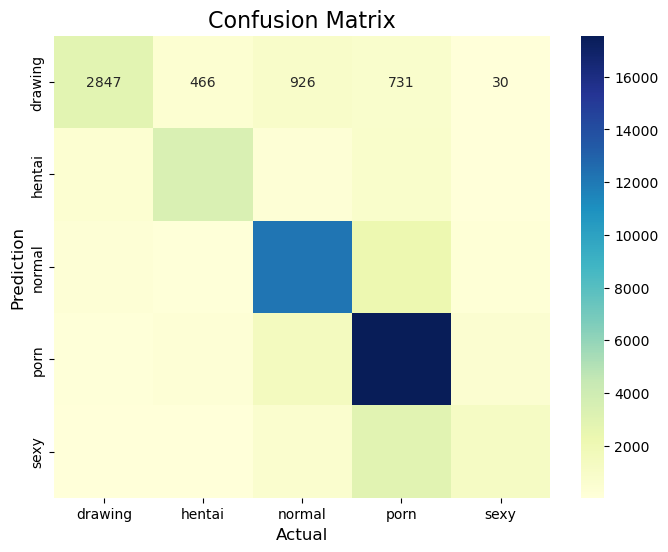

Accuracy: 0.74416
Precision: [0.74159937 0.78561485 0.7835078  0.724      0.6       ]
Recall: [0.5694     0.6772     0.81333333 0.87785    0.2436    ]
F1 Score: [0.64419052 0.7273899  0.79814203 0.79353672 0.34651494]
Classification Report:
               precision    recall  f1-score   support

     drawing       0.74      0.57      0.64      5000
      hentai       0.79      0.68      0.73      5000
      normal       0.78      0.81      0.80     15000
        porn       0.72      0.88      0.79     20000
        sexy       0.60      0.24      0.35      5000

    accuracy                           0.74     50000
   macro avg       0.73      0.64      0.66     50000
weighted avg       0.74      0.74      0.73     50000



In [58]:
# Extract predicted classes from one-hot encoded format
y_pred_classes = np.argmax(y_pred, axis=1)

# Get actual classes
y_true_classes = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average=None)
print("Precision:", precision)

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average=None)
print("Recall:", recall)

# F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average=None)
print("F1 Score:", f1)

# Classification Report
cr = classification_report(y_true_classes, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", cr)


In [98]:
# Create a new Sequential model
model_convnext_tiny2 = Sequential([
    model_ConvNeXtTiny_pre_entrainer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # Output layer with 5 classes
])

In [99]:
# Compile the model with the optimizer
model_convnext_tiny2.compile(optimizer=optimizer,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

In [100]:
model_convnext_tiny2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 768)               27820128  
                                                                 
 flatten_4 (Flatten)         (None, 768)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               393728    
                                                                 
 dense_9 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 28,216,421
Trainable params: 396,293
Non-trainable params: 27,820,128
_________________________________________________________________


In [101]:
checkpoint_filepath2 = r'A:\AI DB\LSPD\models\convnext_tiny_lspd2.keras'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

In [103]:
# Train the model without callbacks
history2 = model_convnext_tiny2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
)

Epoch 1/6
1562/1562 [==============================] - 6800s 4s/step - loss: 0.7715 - accuracy: 0.7234 - val_loss: 0.7776 - val_accuracy: 0.7212
Epoch 2/6
1562/1562 [==============================] - 6737s 4s/step - loss: 0.7680 - accuracy: 0.7240 - val_loss: 0.7766 - val_accuracy: 0.7227
Epoch 3/6
1562/1562 [==============================] - 6779s 4s/step - loss: 0.7659 - accuracy: 0.7252 - val_loss: 0.7733 - val_accuracy: 0.7250
Epoch 4/6
1562/1562 [==============================] - 6772s 4s/step - loss: 0.7638 - accuracy: 0.7259 - val_loss: 0.7718 - val_accuracy: 0.7246
Epoch 5/6
1562/1562 [==============================] - 6777s 4s/step - loss: 0.7627 - accuracy: 0.7258 - val_loss: 0.7712 - val_accuracy: 0.7238
Epoch 6/6
1562/1562 [==============================] - 6741s 4s/step - loss: 0.7614 - accuracy: 0.7269 - val_loss: 0.7734 - val_accuracy: 0.7259


In [118]:

model_convnext_tiny2.save(checkpoint_filepath2,save_format='tf',overwrite=True)

INFO:tensorflow:Assets written to: A:\AI DB\LSPD\models\convnext_tiny_lspd2\assets


INFO:tensorflow:Assets written to: A:\AI DB\LSPD\models\convnext_tiny_lspd2\assets


In [120]:
loaded_model2 = tf.keras.models.load_model(checkpoint_filepath2)

In [104]:
y_pred2 = model_convnext_tiny2.predict(test_generator)

196/196 [==============================] - 745s 4s/step


In [122]:
ypred2=loaded_model2.predict(test_generator)

196/196 [==============================] - 732s 4s/step


In [1]:
# Extract predicted classes from one-hot encoded format
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Get actual classes
y_true_classes2 = test_generator.classes

# Create a confusion matrix
cm2 = confusion_matrix(y_true_classes2, y_pred_classes2)
cmn2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmn2, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show(block=False)

# Accuracy
accuracy2 = accuracy_score(y_true_classes2, y_pred_classes2)
print("Accuracy:", accuracy2)

# Precision
precision2 = precision_score(y_true_classes2, y_pred_classes2, average=None)
print("Precision:", precision2)

# Recall
recall2 = recall_score(y_true_classes2, y_pred_classes2, average=None)
print("Recall:", recall2)

# F1 score
f1_2 = f1_score(y_true_classes2, y_pred_classes2, average=None)
print("F1 Score:", f1_2)

# Classification Report
cr2 = classification_report(y_true_classes2, y_pred_classes2, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", cr2)

NameError: name 'np' is not defined

In [14]:
model_InceptionV3_pre_entrainer = tf.keras.applications.InceptionV3(
                        include_top = False, #vous le définissez sur True si vous utilisez le modèle pour des tâches de classification et False si vous l'utilisez pour l'extraction de caractéristiques.
                        weights = 'imagenet', #signifie que le modèle sera initialisé avec des poids pré-entraînés sur l'ensemble de données ImageNet
                        input_shape = (img_height, img_width,3),
                        pooling = 'avg', #spécifie le type de pooling à appliquer après la dernière couche de convolution 
                    )

for layer in model_InceptionV3_pre_entrainer.layers:
    layer.trainable = False

In [15]:
# Create a new Sequential model
modelInceptionV3 = Sequential([
    model_InceptionV3_pre_entrainer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # Output layer with 5 classes
])

# Compile the model with the optimizer
modelInceptionV3.compile(optimizer=optimizer,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

In [16]:
modelInceptionV3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 22,065,701
Trainable params: 262,917
Non-trainable params: 21,802,784
_________________________________________________________________


In [17]:
checkpoint_filepath3 = r'A:\AI DB\LSPD\models\inceptionv3_lspd.keras'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

In [ ]:
# Train the model without callbacks
history3 = modelInceptionV3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
)

Epoch 1/6


In [ ]:
ypred3=modelInceptionV3.predict(test_generator)

In [ ]:
# Extract predicted classes from one-hot encoded format
y_pred_classes3 = np.argmax(y_pred3, axis=1)

# Get actual classes
y_true_classes3 = test_generator.classes

# Create a confusion matrix
cm3 = confusion_matrix(y_true_classes3, y_pred_classes3)
cmn3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmn3, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show(block=False)

# Accuracy
accuracy3 = accuracy_score(y_true_classes3, y_pred_classes3)
print("Accuracy:", accuracy3)

# Precision
precision3 = precision_score(y_true_classes3, y_pred_classes3, average=None)
print("Precision:", precision3)

# Recall
recall3 = recall_score(y_true_classes3, y_pred_classes3, average=None)
print("Recall:", recall3)

# F1 score
f1_3 = f1_score(y_true_classes3, y_pred_classes3, average=None)
print("F1 Score:", f1_3)

# Classification Report
cr3 = classification_report(y_true_classes3, y_pred_classes3, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", cr3)